### Load necessary packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import json
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster import hierarchy
from load_data import load_annotation, load_mouselight


### Read in the table that describes the relation between ccf structures

In [2]:
ccf_structures = pd.read_csv('/data/allen_mouse_ccf/annotation/adult_mouse_ccf_structures.csv')

### Functions for organizing the data and plotting

In [3]:
def create_projection_row(axons,ccf_structures):
    """
    Creates a vector of axon end-point numbers in each Allen compartment for a given reconstruction.
    Parents contain the endpoints of all daughters.
    
    Parameters
    ----------
    axons : pandas DataFrame
        DataFrame of the axon annotations
    ccf_structures: pandas DataFrame
        dataframe containing ccf structure data, directly loaded from "adult_mouse_ccf_structures.csv"
    
    Returns
    -------
    end_points_row : 1d array
        vecrotr containing the number of endpoints in each ccf compartment (parents included)
    end_point_num : int
        total number of axon endpoints
    """
    end_points_row = np.zeros(len(ccf_structures)) # initialize endpoint numbers to 0
    end_point_num = 0
    endpoint_sampleNumbers = np.sort(list(set(axons.sampleNumber)-set(axons.parentNumber))) # find the set of nodes that are not parents
    for sampleNumber in endpoint_sampleNumbers:
        allenId = axons[axons.sampleNumber == sampleNumber].allenId.values[0]
        if allenId == None:
            continue # there are cells outside the ccf
        if np.isnan(allenId): # endpoint outside the CCF
            continue
        end_point_num += 1
        structure_id_path = np.asarray(ccf_structures[ccf_structures.id == allenId].structure_id_path.values[0].strip('/').split('/'),int) # put all the parent structures in a list
        for structure_id in structure_id_path:
            ccf_idx = np.where(ccf_structures.id.values == structure_id)[0][0]
            end_points_row[ccf_idx] += 1
    #print('{} endpoints out of {}'.format(end_point_num,len(endpoint_sampleNumbers)))
    return end_points_row, end_point_num

def filter_allen_compartments_by_depth(ccf_structures,parameters_dict):
    """
    filters ccf compartments based on desired depth
    
    Parameters
    ----------
    ccf_structures: pandas DataFrame
        dataframe containing ccf structure data, directly loaded from "adult_mouse_ccf_structures.csv"
    parameters_dict : dictionary
        contains minimum depth (global) and maximum depth for all major brain regions
    e.g.:
    parameters_dict = {'minimum_depth':2, # there is no information below this depth in the ccf
                   'maximum_depth_dict': {'Hindbrain':4, #%  defining maximum depth to be considered in analysis
                                          'Interbrain':4,
                                          'Midbrain':3,
                                          'Cerebellar cortex':2,
                                          'Cerebellar nuclei':2,
                                          'Cerebral cortex': 3,
                                          'Cerebral nuclei':3}
                                          }
    Returns
    -------
    needed_allen_compartments : 1d array of boolean
        vector stating if a given ccf compartment should stay (true) or should be ignored (false)
    """
    max_depth_dict = parameters_dict['maximum_depth_dict']
    base_brainregion_names = list()
    base_brainregion_ids = list()
    base_brainregion_max_depths = list()
    parentids = list()
    for brainregion_now in max_depth_dict.keys():
        base_brainregion_ids.append(ccf_structures.loc[ccf_structures['name']==brainregion_now,'id'].values[0])
        parentids.extend(np.asarray(ccf_structures.loc[ccf_structures['name']==brainregion_now,'structure_id_path'].values[0].strip('/').split('/'),int))
        base_brainregion_names.append(brainregion_now)
        base_brainregion_max_depths.append(max_depth_dict[brainregion_now])
    parentids = np.unique(parentids)
    needed_allen_compartments = list()
    for allen_row in ccf_structures.iterrows():
        allen_row = allen_row[1]
        depth = len(allen_row.structure_id_path.strip('/').split('/'))-1
        if depth < parameters_dict['minimum_depth']:
            needed_allen_compartments.append(False)
            continue
        id_path = np.asarray(allen_row['structure_id_path'].strip('/').split('/'),int)
        if 8 not in id_path:
            needed_allen_compartments.append(False)
            continue
        if id_path[-1] in parentids:
            needed_allen_compartments.append(True)
            continue
        for base_brainregion_id,base_brainregion_name,base_brainregion_max_depth in zip(base_brainregion_ids,base_brainregion_names,base_brainregion_max_depths):
            brainregion_found = False
            if base_brainregion_id in id_path:
                if depth <= base_brainregion_max_depth:
                    needed_allen_compartments.append(True)
                else:
                    needed_allen_compartments.append(False)
                brainregion_found = True
                break
        if brainregion_found:
            continue
        needed_allen_compartments.append(False)

    return needed_allen_compartments

def plot_projection_patterns(projection_matrix,
                             base_nuclei= ['Cerebellar cortex','Cerebellar nuclei','Medulla','Pons','Midbrain','Thalamus','Hypothalamus'],
                             figsize = [20,12],
                             gridcolor = 'black',#'white',
                             gridwidth = .5,
                             label_size = 7):
    """
    plots projection pattern heatmaps at three consecutive depths
    
    Parameters
    ----------
     projection_matrix: matrix of int (cells x brain regions)
     base_nuclei: list of starter nuclei as written in ccf  e.g.: ['Cerebellar cortex','Cerebellar nuclei','Medulla','Pons','Midbrain','Thalamus','Hypothalamus'],
     figsize: list of float, e.g.: [20,12]
     gridcolor : str, color of grid
     gridwidth : float, width of grid
     label_size : int, size of texts
    Returns
    -------
    three plots
    """
    
    cmap = plt.cm.RdPu_r
    cmap.set_under(color='dimgray')
    plt.style.use('default')
    projection_matrix_to_use = projection_matrix.copy()
    
    cellorder = cell_order_clust
    vmin = 0.000001
    
    base_nuclei_idx = list()
    base_nuclei_structureId = list()
    header = list()
    projection_pattern= list()
    for base_nucleus in base_nuclei:
        base_nucleus_idx_ipsi = (ccf_structures['name']==base_nucleus).argmax()
        base_nucleus_structureId = ccf_structures['id'][base_nucleus_idx_ipsi]
        base_nuclei_idx.append(base_nucleus_idx_ipsi)
        base_nuclei_structureId.append(base_nucleus_structureId)
    
        header.append('{}'.format(base_nucleus))
        projection_pattern.append(projection_matrix_to_use[:,base_nucleus_idx_ipsi])
    
    projection_pattern_now = projection_pattern
    header_now = header
    
    fig = plt.figure(figsize = figsize)
    ax=fig.add_subplot(111)
    im = ax.pcolormesh(np.asarray(projection_pattern_now).T[cellorder,:],
                       cmap = cmap,
                       edgecolor= gridcolor,
                       linewidth=gridwidth,
                       vmin=vmin) #ax.imshow(np.asarray(projection_pattern).T[cellorder,:],aspect='auto',cmap = 'RdPu')
    ax.set_yticks(np.arange(0,len(cell_names))+.5)
    ax.set_yticklabels(cell_names[cellorder])
    ax.set_xticks(np.arange(0,len(header_now))+.5)
    ax.set_xticklabels(header_now)
    fig.colorbar(im, ax=ax,label = 'proportion of axon endings')
    ax.tick_params(axis='x',labelsize = label_size)
    ax.tick_params(axis='y',labelsize =label_size)
    
    
    child_nuclei_structureId = list()
    children_structureId = list()
    projection_pattern = list()
    header = list()
    for base_structureid in base_nuclei_structureId:
        children_idxs = np.where(ccf_structures['parent_structure_id'] == base_structureid)[0]
        if len(children_idxs) == 0: # in case there are no children, we keep the parents
            children_idxs = np.where(ccf_structures['id'] == base_structureid)[0]
            print('end of tree reached at {}'.format(ccf_structures['name'][children_idxs[0]]))
        for children_idx in children_idxs:
            
            children_nucleus = ccf_structures['acronym'][children_idx]
            children_structureId = ccf_structures['id'][children_idx]
            child_nuclei_structureId.append(children_structureId)
            header.append('{}'.format(children_nucleus))
            projection_pattern.append(projection_matrix_to_use[:,children_idx])
    tokeep = np.sum(np.asarray(projection_pattern),1)>0    
    projection_pattern_orig = np.asarray(projection_pattern).T
    projection_pattern = projection_pattern_orig[:,tokeep] 
    header=np.asarray(header)[tokeep]  
    #% plot
    
    projection_pattern_now = projection_pattern
    header_now = header
    
    fig = plt.figure(figsize = figsize)
    ax=fig.add_subplot(111)
    
    im = ax.pcolormesh(projection_pattern_now[cellorder,:],
                       cmap = cmap,
                       edgecolor= gridcolor,
                       linewidth=gridwidth,
                       vmin=vmin)
    ax.set_yticks(np.arange(0,len(cell_names))+.5)
    ax.set_yticklabels(cell_names[cellorder])
    ax.set_xticks(np.arange(0,len(header_now))+.5)
    ax.set_xticklabels(header_now)
    fig.colorbar(im, ax=ax,label = 'proportion of axon endings')
    ax.tick_params(axis='x',labelsize =label_size)
    ax.tick_params(axis='y',labelsize = label_size)
    
    
    
    #% grandchildren
    grandchild_nuclei_structureId = list()
    projection_pattern = list()
    grandchildren_name_acronym = list()
    header = list()
    for children_structureid in child_nuclei_structureId:
        grandchildren_idxs = np.where(ccf_structures['parent_structure_id'] == children_structureid)[0]
        if len(grandchildren_idxs) == 0: # in case there are no children, we keep the parents
            grandchildren_idxs = np.where(ccf_structures['id'] == children_structureid)[0]
            print('end of tree reached at {}'.format(ccf_structures['name'][grandchildren_idxs[0]]))
        if children_structureid in [856,864]: #these two structures (thalamus) are further divided
            #print(grandchildren_idxs)
            grandchildren_idxs_real = list()
            for grandchildren_idx in grandchildren_idxs:
                grandchildren_idxs_real.append(np.where(ccf_structures['parent_structure_id'] == ccf_structures['id'][grandchildren_idx])[0])
            grandchildren_idxs = np.concatenate(grandchildren_idxs_real)
            #print(grandchildren_idxs)
        for grandchildren_idx in grandchildren_idxs:
            
            grandchildren_acronym = ccf_structures['acronym'][grandchildren_idx]
            grandchildren_name_acronym = grandchildren_acronym#'{} - {}'.format(grandchildren_acronym,grandchildren_nucleus)
            grandchildren_structureId = ccf_structures['id'][grandchildren_idx]
            grandchild_nuclei_structureId.append(grandchildren_structureId)
    
            header.append('{}'.format(grandchildren_name_acronym))
            projection_pattern.append(projection_matrix_to_use[:,grandchildren_idx])
    #%
    tokeep = np.sum(np.asarray(projection_pattern),1)>0    
    projection_pattern_orig = np.asarray(projection_pattern).T
    projection_pattern = projection_pattern_orig[:,tokeep] 
    header=np.asarray(header)[tokeep]   
    
    projection_pattern_now = projection_pattern
    header_now = header
    
    fig = plt.figure(figsize = figsize)
    ax=fig.add_subplot(111)
    im = ax.pcolormesh(projection_pattern_now[cellorder,:],
                       cmap = cmap,
                       edgecolor= gridcolor,
                       linewidth=gridwidth,
                       vmin=vmin)
    ax.set_yticks(np.arange(0,len(cell_names))+.5)
    ax.set_yticklabels(cell_names[cellorder])
    plt.xticks(np.arange(0,len(header_now))+.5,header_now,rotation='vertical')
    #ax.set_xticklabels(header)
    fig.colorbar(im, ax=ax,label = 'proportion of axon endings')   
    ax.tick_params(axis='x',labelsize = label_size)     
    ax.tick_params(axis='y',labelsize = label_size)
    plt.xticks(rotation = 70)
    print('done')

### Iterate through all the cells and save the axon end point locations for all cells that are located in the medulla

In [4]:
# we will be looking for cells that are located in the medulla 
medulla_ccf_id = ccf_structures[ccf_structures.name == 'Medulla'].id.values[0] # - change this to whatever brain region you are interested in - pick a name from ccf_structures.name

cell_names = []
projection_matrix = []
total_end_point_numbers = []
needed_cells = 10000 # set this value to lower if you don't want to wait for all the 94 cells to be loaded
for i,neuron_id in enumerate(np.arange(1,1507)[::-1]):
    neuron = 'AA'+str(neuron_id).zfill(4)
    try:
        (axons, dendrites) = load_mouselight(neuron)
    except:
        print('could not load {}'.format(neuron))
        continue
    soma_allen_id = axons.allenId.loc[0] # where is the soma in the ccf
    if soma_allen_id == None:
        continue # there are cells outside the ccf
    elif np.isnan(soma_allen_id): # there are cells outside the ccf
        continue
    structure_id_path = np.asarray(ccf_structures[ccf_structures.id == soma_allen_id].structure_id_path.values[0].strip('/').split('/'),int) # put all the parent structures in a list
    if medulla_ccf_id in structure_id_path: 
        print(neuron)
        
        end_points_row,end_point_num = create_projection_row(axons,ccf_structures) # assign axon endings to ccf compartments, parents as well
        if end_point_num>10: # cells are ignored that have less then 10 axon endings in the CCF
            projection_matrix.append(end_points_row)
            total_end_point_numbers.append(end_point_num)
            cell_names.append(neuron)
    if len (cell_names)>=needed_cells:
        break
projection_matrix = np.asarray(projection_matrix)
total_end_point_numbers = np.asarray(total_end_point_numbers)
cell_names = np.asarray(cell_names)

AA1489
AA1461
AA1460
AA1458
AA1455
AA1454
AA1453
AA1452
AA1431
AA1429
AA1428
AA1427
AA1426
AA1424
AA1422
AA1405
AA1404
AA1402
AA1362
AA1361
AA1360
AA1359
AA1358
AA1357
AA1356
AA1354
AA1353
AA1352
AA1351
AA1350
AA1349
AA1348
AA1347
AA1346
AA1345
AA1344
AA1343
AA1342
AA1341
AA1340
AA1339
AA1338
AA1337
AA1336
AA1335
AA1334
AA1333
AA1332
AA1331
AA1330
AA1329
AA1328
AA1327
AA1326
AA1325
AA1313
AA1310
AA1308
AA1295
AA1263
AA1196
AA1093
AA1085
AA1084
AA1083
AA1082
AA1077
AA1075
AA1070
AA1069
AA1068
AA1065
AA1064
AA1063
AA1062
AA1056
AA1030
AA0996
AA0989
AA0953
AA0951
AA0950
AA0948
AA0947
AA0922
AA0517
AA0516
AA0515
AA0508
AA0504
AA0503
AA0434
AA0431
AA0430


### Set parameters for clustering
You can set maximum depth for each brain region separately

In [5]:
parameters_dict = {'minimum_depth':2, # there is not much information below this depth in the ccf
                   'maximum_depth_dict': {'Hindbrain':4, # defining maximum depth to be considered in analysis - set these numbers higher to get finer distinction between cells
                                          'Interbrain':4, #
                                          'Midbrain':3,
                                          'Cerebellar cortex':2,
                                          'Cerebellar nuclei':2,
                                          'Cerebral cortex': 3,
                                          'Cerebral nuclei':3}
                  }
needed_allen_compartments = filter_allen_compartments_by_depth(ccf_structures,parameters_dict) # this function filters the allen compartments by depth - for clustering
projection_matrix_now= projection_matrix[:,needed_allen_compartments]
projection_matrix_now_normalized = projection_matrix_now/ total_end_point_numbers[:,np.newaxis]

### cluster cells by their projection patterns
the order of cells will be used on the following projection pattern heatmaps (cell_order_clust)

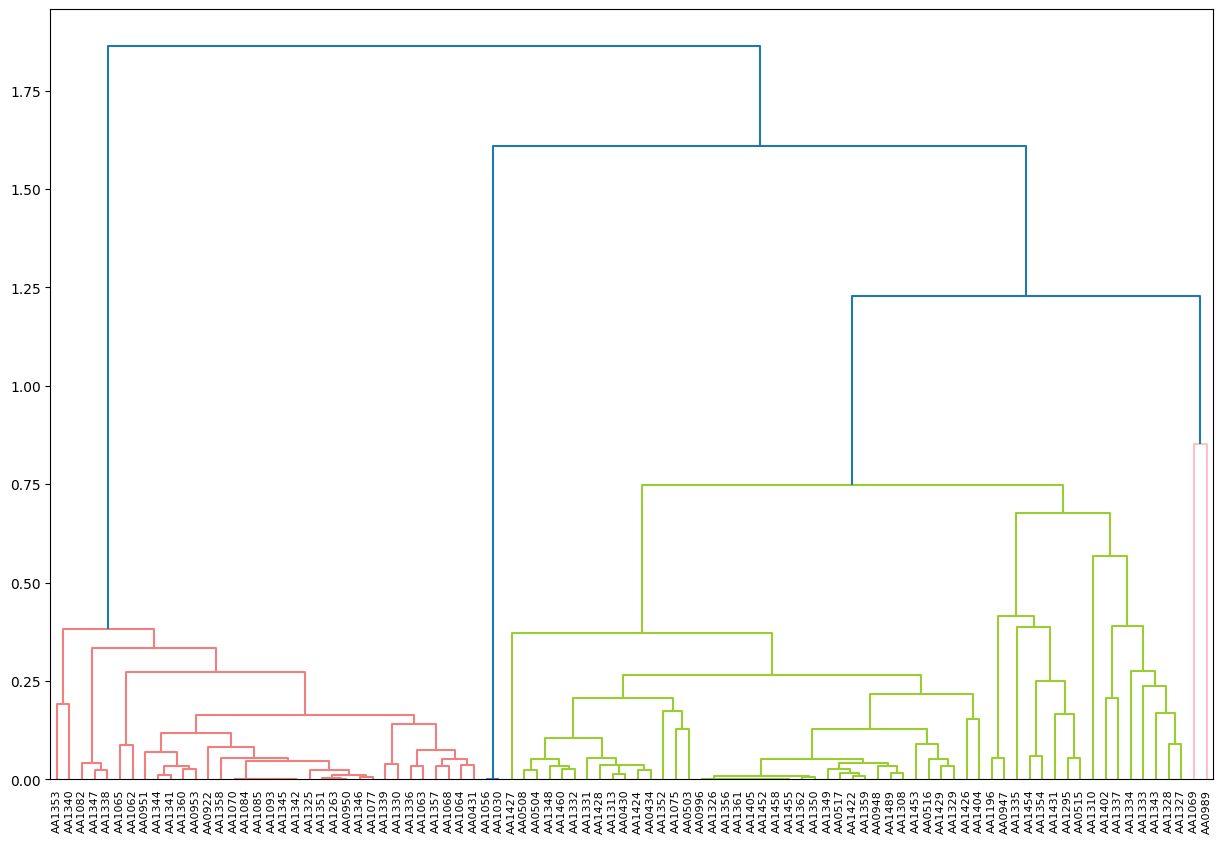

In [6]:
plt.style.use('default')
hierarchy.set_link_color_palette(['lightcoral','dodgerblue','yellowgreen','pink'])
linked = linkage(projection_matrix_now_normalized,'weighted') #'weighted' 'ward' 'complete'

fig_cluster = plt.figure(figsize=(15, 10))
ax_clust = fig_cluster.add_subplot(111)
R = dendrogram(linked,
               orientation='top',
               labels=cell_names,
               color_threshold=1)
cell_order_clust = list()
for i,cell_ID in enumerate(R['ivl']):
    cell_idx = np.asarray(cell_names) == cell_ID
    cell_order_clust.append(np.where(cell_idx)[0][0])
ax_clust.tick_params(axis='x', which='major', labelsize=8) 
cell_order_clust = np.asarray(cell_order_clust)

### projection pattern heatmaps at three different depths

end of tree reached at Cerebellar cortex, Purkinje layer
end of tree reached at Cerebellar cortex, granular layer
end of tree reached at Cerebellar cortex, molecular layer
end of tree reached at Dentate nucleus
end of tree reached at Vestibulocerebellar nucleus
end of tree reached at Fastigial nucleus
end of tree reached at Interposed nucleus
end of tree reached at Median eminence
done


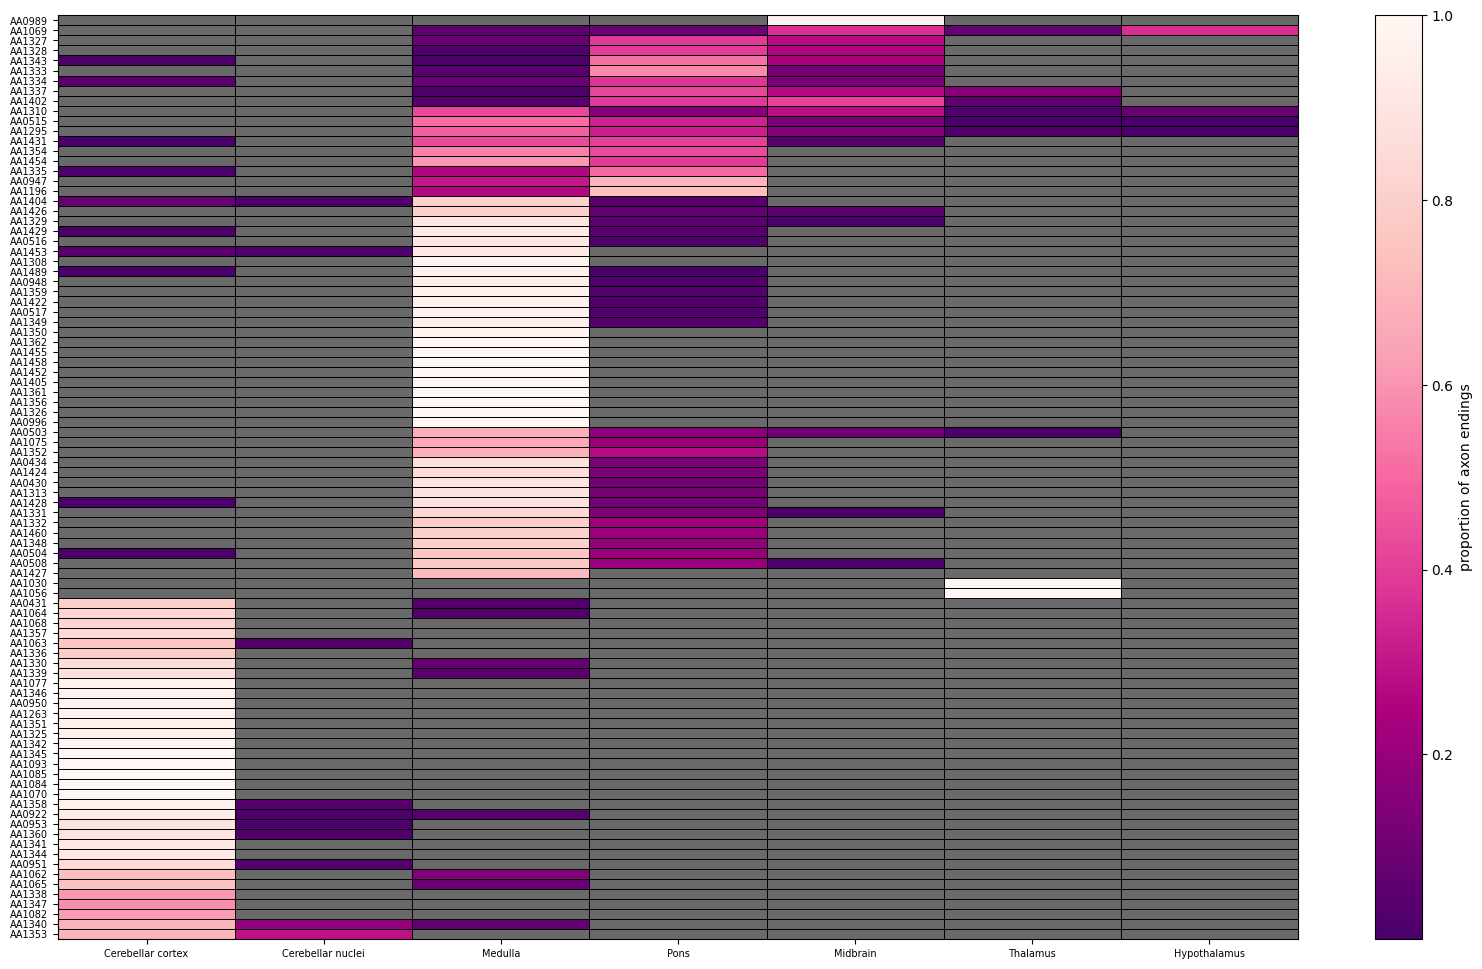

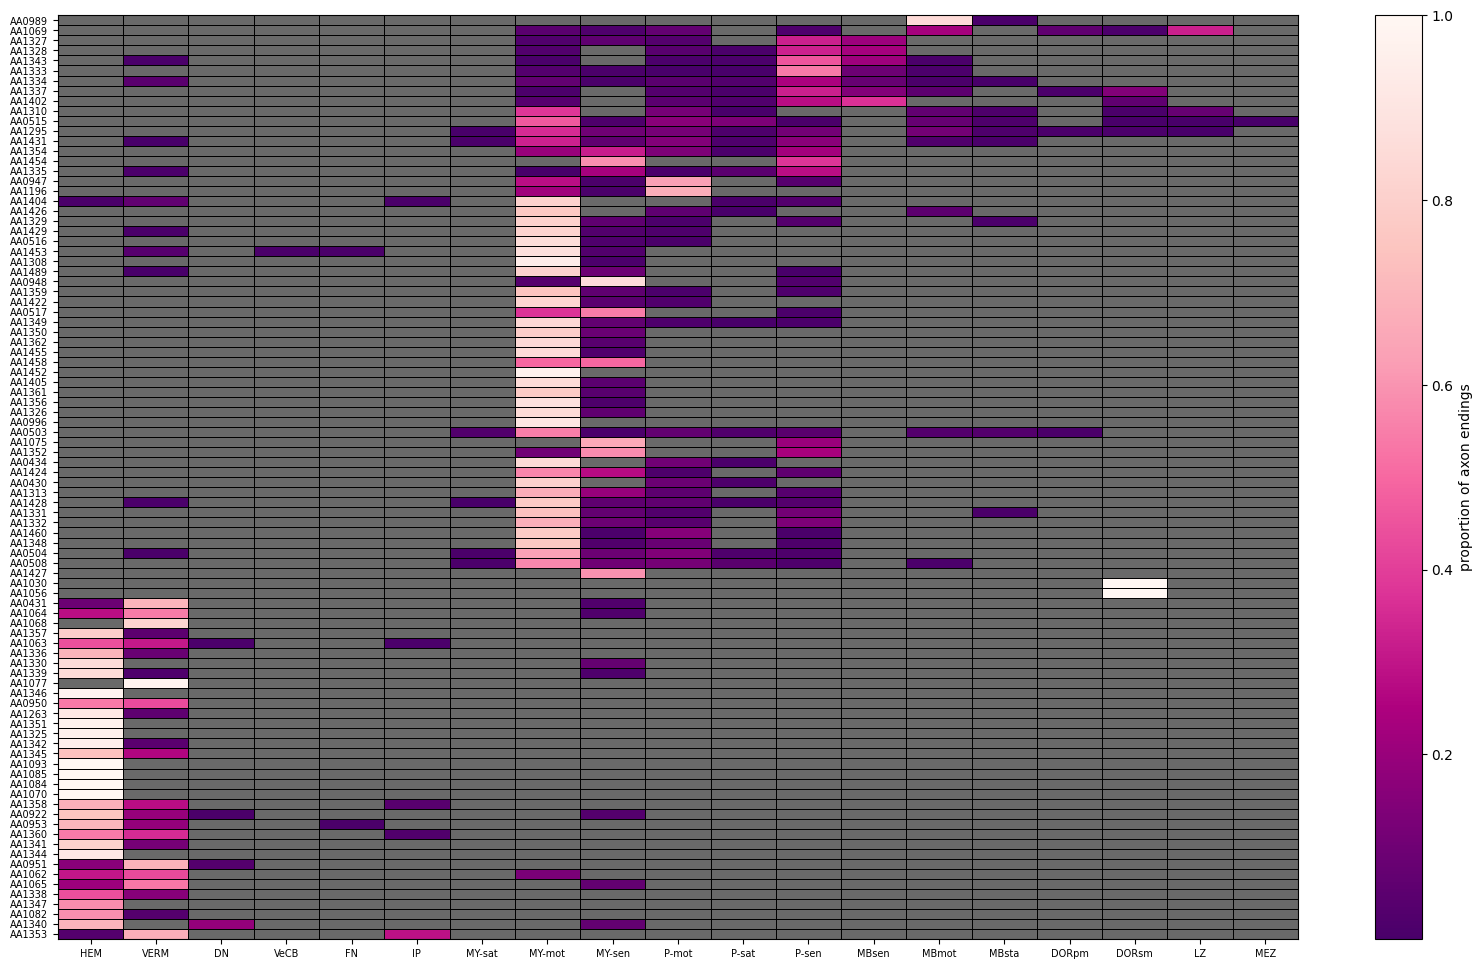

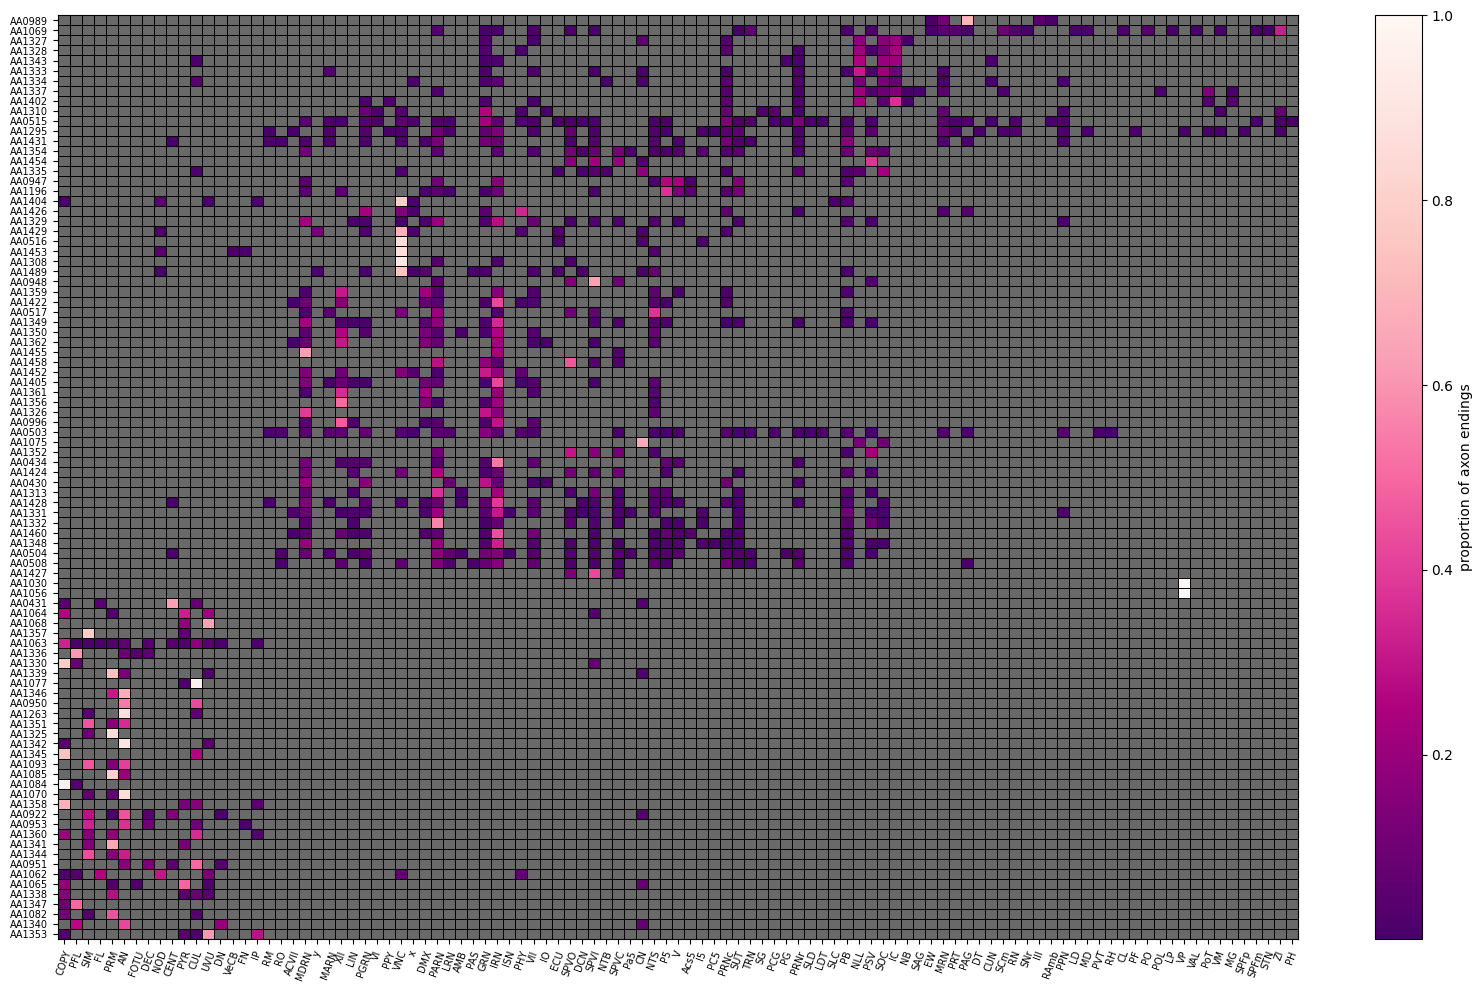

In [7]:
gridcolor = 'black'#'white',
gridwidth = .5
label_size = 7
figsize = [20,12]
base_nuclei =  ['Cerebellar cortex','Cerebellar nuclei','Medulla','Pons','Midbrain','Thalamus','Hypothalamus']#,'fiber tracts', 'ventricular systems']


plot_projection_patterns(projection_matrix/ total_end_point_numbers[:,np.newaxis],
                         base_nuclei= base_nuclei,
                         figsize = figsize,
                         gridcolor = gridcolor,
                         gridwidth = gridwidth,
                         label_size = label_size)
